# Environmental Sound Classification Dataset Tutorial: Loading, Filtering, Plotting, and Saving ESC-50 Data

This tutorial goes over the basics of how to read, filter, and plot data from a curated PKL file containing the audio waveforms and associated metadata from ESC-50, an open-access dataset of environmental sound recordings.

ESC-50 was released by Karol Piczak in 2015. For information on ESC-50, see its __[original paper](https://doi.org/10.1145/2733373.2806390)__, __[webpage on Papers with Code](https://paperswithcode.com/dataset/esc-50)__, or __[GitHub repository.](https://github.com/karolpiczak/ESC-50)__.

PKL files containing a single ESC-50 recording downsampled to 800Hz and 16kHz, respectively, are included with this tutorial. The full ESC-50 dataset can be downloaded as a collection of .wav files at 44.1kHz sampling frequency from __[GitHub](https://github.com/karolpiczak/ESC-50)__ or consolidated PKL files downsampled to either 800Hz or 16kHz sampling frequency from __[Google Drive](https://drive.google.com/drive/folders/1QKHUzdT0et6xpKXm8LFOmHJ9_gx0J2ib?usp=sharing)__ (contact Sarah Popenhagen at spopen@hawaii.edu for access to Google Drive folder). Conversion to numpy arrays and downsampling was performed using the tensorflow function audio.decode_wav() and the tensorflow-io function audio.resample().

For examples of how to use ESC-50 data in machine learning applications, see:

Takazawa, S.K.; Popenhagen, S.K.; Ocampo Giraldo, L.A.; Hix, J.D.; Thompson, S.J.; Chichester, D.L.;Zeiler, C.P.; Garcés, M.A. Explosion Detection Using Smartphones: Ensemble Learning with the Smartphone High-Explosive Audio Recordings Dataset and the ESC-50 Dataset. Sensors 2024, 24, 6688. https://doi.org/10.3390/s24206688

Popenhagen, S.K.; Takazawa, S.K.; Garcés, M.A. Rocket Launch Detection with Smartphone Audio and Transfer Learning. Signals 2025 (accepted).

## Section 0: Prerequisites and Imports
The following cell includes the imports necessary to run this tutorial.

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
from scipy import signal
from quantum_inferno.plot_templates.plot_templates_examples import plot_wf_mesh_vert_example
from quantum_inferno.cwt_atoms import cwt_chirp_from_sig

## Section 1: Loading the Dataset

In the following cell, we'll define the path to the dataset. By default, this path will point to the single-recording subsets of ESC-50 included with this tutorial.

After you've completed the tutorial with this file, feel free to download the full ESC-50 dataset PKL files and use the last two lines of the cell to change the 'PATH_TO_PKL_800' and 'PATH_TO_PKL_16k' variables to point to the 'esc50_df_800Hz.pkl' and 'esc50_df_16kHz.pkl' file locations on your device.

In [19]:
TUTORIAL_PICKLE_FILE_NAME_800 = "esc50_tutorial_800Hz.pkl"
TUTORIAL_PICKLE_FILE_NAME_16k = "esc50_tutorial_16kHz.pkl"

CURRENT_DIRECTORY = os.getcwd()

PATH_TO_TUTORIAL_PKL_800 = os.path.join(CURRENT_DIRECTORY, TUTORIAL_PICKLE_FILE_NAME_800)
PATH_TO_TUTORIAL_PKL_16k = os.path.join(CURRENT_DIRECTORY, TUTORIAL_PICKLE_FILE_NAME_16k)
PATH_TO_PKL_800 = PATH_TO_TUTORIAL_PKL_800
PATH_TO_PKL_16k = PATH_TO_TUTORIAL_PKL_16k

# PATH_TO_PKL_800 = "<insert path to esc50_df_800Hz.pkl on your device here>"
# PATH_TO_PKL_16k = "<insert path to esc50_df_16kHz.pkl on your device here>"


Once we have the locations of the files, we can read the data using the pandas module.

In [25]:
esc50_ds_16k = pd.read_pickle(PATH_TO_PKL_16k)
esc50_ds_800 = pd.read_pickle(PATH_TO_PKL_800)
esc50_ds_16k.head()

,clip_id,waveform,fs,target,inferred_class,true_class
1223,freesound103050,"[4.936072e-10, 6.7471073e-10, 2.0322156e-08, -...",16000.0,19,"Heart sounds, heartbeat",thunderstorm


In [26]:
esc50_ds_800.head()

,clip_id,waveform,fs,target,inferred_class,true_class
1223,freesound103050,"[2.5659494e-11, 1.7888557e-09, -9.4770115e-08,...",800.0,19,"Heart sounds, heartbeat",thunderstorm


The structure of both pandas DataFrames (800Hz and 16kHz) is identical. Each row contains the identification number of the Freesound audio file the 5 s long audio clip was taken from, the waveform downsampled to either 800Hz or 16kHz, the sampling rate the waveform was downsampled to, the target (an integer value assigned to the ESC-50 class associated with the clip), the name of the ESC-50 class, and the name of the class predicted by Google's YAMNet audio classification model. 

To keep track of all the column names, we'll define the 'ESC50Labels' class, and then initiate an instance of it in the next cell.

In [22]:
class ESC50Labels:
    """
    A class containing the column names used in the ESC-50 pickle files.
    """
    def __init__(
            self,
            clip_id: str = "clip_id",
            audio_data: str = "waveform",
            audio_fs: str = "fs",
            esc50_target: str = "target",
            esc50_true_class: str = "true_class",
            yamnet_predicted_class: str = "inferred_class",
    ):
        """
        Defaults should be left in place for compatibility with the ESC-50 pickle files.
        :param clip_id: the ID string of the Freesound clip the audio was taken from, e.g. "freesound123456"
        :param audio_data: a numpy array containing the raw audio waveform amplitudes
        :param audio_fs: the sampling frequency of the audio waveform in Hz, e.g. 800 or 16000
        :param esc50_target: the target class number of the ESC-50 class, e.g. 37 for "clock_alarm"
        :param esc50_true_class: the name of the true ESC-50 class, e.g. "clock_alarm"
        :param yamnet_predicted_class: the name of the top class predicted by YAMNet, e.g. "Tools"
        """
        self.clip_id = clip_id
        self.audio_data = audio_data
        self.audio_fs = audio_fs
        self.esc50_target = esc50_target
        self.esc50_true_class = esc50_true_class
        self.yamnet_predicted_class = yamnet_predicted_class

In [23]:
ds_labels = ESC50Labels()

With the labels now easily accessible, we'll print out some metadata about the recording(s) in the files..

Notice how the desired fields are accessed using the column names stored in `ds_labels`.

In [28]:
for esc50_ds in [esc50_ds_16k, esc50_ds_800]:
    fs = int(esc50_ds[ds_labels.audio_fs][esc50_ds.index[0]])
    print(f"\nESC-50 dataset at {fs}Hz:")
    # get some details about the dataset and print them out
    n_signals = len(esc50_ds)
    n_clips = len(np.unique(esc50_ds[ds_labels.clip_id]))
    classes, counts = np.unique(esc50_ds[ds_labels.esc50_true_class], return_counts=True)
    print(f"\tThis dataset contains {n_signals} 5 s long samples from {n_clips} different Freesound audio clips assigned to")
    print(f"\t{len(classes)} unique classes.")


ESC-50 dataset at 16000Hz:
	This dataset contains 1 5 s long samples from 1 different Freesound audio clips assigned to
	1 unique classes.

ESC-50 dataset at 800Hz:
	This dataset contains 1 5 s long samples from 1 different Freesound audio clips assigned to
	1 unique classes.


We can also loop through each Freesound ID in the dataset and look at the classes of the samples taken from them.

In [30]:
for esc50_ds in [esc50_ds_16k, esc50_ds_800]:
    fs = int(esc50_ds[ds_labels.audio_fs][esc50_ds.index[0]])
    print(f"\nESC-50 dataset at {fs}Hz:")
    clips = np.unique(esc50_ds[ds_labels.clip_id])
    for clip_id in clips:
        clip_ds = esc50_ds[esc50_ds[ds_labels.clip_id] == clip_id]
        classes, counts = np.unique(clip_ds[ds_labels.esc50_true_class], return_counts=True)
        class_summary = f"\t{clip_id}: "
        for class_name, class_count in zip(classes, counts):
            class_summary += f"'{class_name}': {class_count} sample(s),"
        print(class_summary[:-1])



ESC-50 dataset at 16000Hz:
	freesound103050: 'thunderstorm': 1 sample(s)

ESC-50 dataset at 800Hz:
	freesound103050: 'thunderstorm': 1 sample(s)


## Section 2: Filtering the Dataset

The files can be filtered easily using any of the included metadata fields. For example, you could select a subset of the 800Hz dataset containing only samples classified by YAMNet as "Heartbeat" using this line of code:

```python
heartbeat_df_800 = esc50_ds_800[esc50_ds_800[ds_labels.yamnet_inferred_class] == "Heartbeat"]
```

For this tutorial, we'll select a subset of the dataset containing only the data associated with the clip ID 'freesound103050'.

By selecting only those rows with "freesound103050" in their clip ID field, we create a subset of the dataset containing all available data from our chosen Freesound clip and no data from any other audio clips in the file.

In [31]:
ex_clip_id: str = "freesound103050"
ex_clip_df_800 = esc50_ds_800[esc50_ds_800[ds_labels.clip_id] == ex_clip_id]
ex_clip_df_16k = esc50_ds_16k[esc50_ds_16k[ds_labels.clip_id] == ex_clip_id]
ex_clip_df_800

,clip_id,waveform,fs,target,inferred_class,true_class
1223,freesound103050,"[2.5659494e-11, 1.7888557e-09, -9.4770115e-08,...",800.0,19,"Heart sounds, heartbeat",thunderstorm


In [32]:
ex_clip_df_16k

,clip_id,waveform,fs,target,inferred_class,true_class
1223,freesound103050,"[4.936072e-10, 6.7471073e-10, 2.0322156e-08, -...",16000.0,19,"Heart sounds, heartbeat",thunderstorm


## Section 3: Plotting ESC-50 Data

To plot ESC-50 audio data, the time array must be reconstructed from the sample rate and length of the waveform.  We use numpy to do this.

In the following cell, we'll define two functions: one to calculate the rolling mean of a waveform and another to visualize the data from a single ESC-50 sample in the time domain as well as the frequency domain. Read through the comments in the functions for a detailed explanation of each step.

In [33]:
# a colorblind-friendly color cycle to use in our plots
CBF_COLOR_CYCLE = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']


def rolling_mean(signal: np.ndarray, fs: float, window_length_s: float = 0.01) -> np.ndarray:
    """
    Calculate the rolling mean of a signal using a specified window length in seconds.

    :param signal: The input signal as a NumPy array
    :param window_length_s: The length of the rolling window in seconds
    :return: A NumPy array containing the rolling mean of the input signal
    """
    pad: int = int(fs * window_length_s / 2)
    window_size: int = int(pad * 2 + 1)
    roll_mean = []
    for idx_i in range(len(signal)):
        if idx_i <= pad:
            sig_slice = signal[:window_size]
        elif idx_i + pad >= len(signal):
            sig_slice = signal[-window_size:]
        else:
            sig_slice = signal[int(idx_i - pad): int(idx_i + pad + 1)]
        if len(sig_slice) != window_size:
            raise ValueError(f"Signal slice length {len(sig_slice)} does not match window size {window_size}.")
        roll_mean.append(np.nanmean(sig_slice))
    return np.array(roll_mean)



def single_sample_example_plots(esc50_ds, ds_labels, sample_idx, plot_tfr=True, roll_mean=True, fontsize=12, figure_size=(10,7)):
    sample_fs = esc50_ds[ds_labels.audio_fs][sample_idx]
    sample_waveform = esc50_ds[ds_labels.audio_data][sample_idx]
    # We'll demean and normalize the waveform to the range [-1, 1] for cleaner visualization
    if roll_mean:
        # Calculate the mean of the waveform with a rolling window approximately 0.01 seconds in duration
        sample_mean = rolling_mean(sample_waveform, fs=sample_fs, window_length_s=0.01)
    else:
        # Calculate the mean of the whole waveform
        sample_mean = np.nanmean(sample_waveform)
    # Demean
    sample_waveform = sample_waveform - sample_mean
    # Normalize to the range [-1, 1]
    sample_waveform = sample_waveform / np.nanmax(np.abs(sample_waveform))

    # We'll also extract the true class, the class predicted by YAMNet, and the clip ID of the sample to add to the plot title
    sample_esc50_class = esc50_ds[ds_labels.esc50_true_class][sample_idx]
    sample_yamnet_class = esc50_ds[ds_labels.yamnet_predicted_class][sample_idx]
    sample_clip_id = esc50_ds[ds_labels.clip_id][sample_idx]

    # To visualize the data in the time domain, we must reconstruct the time array
    sample_time_array = np.arange(len(sample_waveform)) / sample_fs

    # To visualize the frequency content of the sample, we'll calculate and plot the Welch 
    # power spectral density (PSD) of the waveform as well.
    nperseg = sample_fs * 0.48  # 0.48 seconds per segment
    f, Pxx_den = signal.welch(sample_waveform, sample_fs, nperseg=nperseg)

    # Time domain and frequency domain figure set-up
    fig, ax = plt.subplots(2, 1, figsize=figure_size)
    xlabel = "Time (s)"
    title = f"ESC-50 PKL index {sample_idx} audio downsampled to {int(sample_fs)}Hz"
    title += f"\nClip ID: {sample_clip_id}, ESC-50 class: {sample_esc50_class}\nClass predicted by YAMNet"
    if sample_fs < 16000.0:
        title += " after upsampling"
    title += f": {sample_yamnet_class}"
    # Plot the waveform
    ax[0].plot(sample_time_array, sample_waveform, lw=1, color="k")
    # Plot the PSD
    ax[1].plot(f, Pxx_den, lw=1, color="k")
    # Time domain panel settings
    ax[0].set(xlim=(sample_time_array[0], sample_time_array[-1]), ylim=(-1.1, 1.1))
    ax[0].set_title(title, fontsize=fontsize + 2)
    ax[0].set_xlabel(xlabel, fontsize=fontsize)
    ax[0].set_ylabel("Normalized waveform", fontsize=fontsize)
    # Frequency domain panel settings
    ax[1].set(xlim=(0, sample_fs / 2), ylim=(0, np.max(Pxx_den) * 1.05))
    ax[1].set_xlabel("Frequency (Hz)", fontsize=fontsize)
    ax[1].set_ylabel("Power spectral density (PSD)", fontsize=fontsize)

    plt.subplots_adjust()

    # If desired, we can also visualize the data in the time-frequency domain. To do this, we calculate and plot the 
    # continuous wavelet transform (CWT) of the audio data using functions in the quantum_inferno module
    if plot_tfr:
        tfr_title = f"CWT and waveform from ESC-50 PKL index {sample_idx} (clip ID {sample_clip_id})"
        _, cwt_bits, time_s, frequency_cwt_hz = cwt_chirp_from_sig(
            sig_wf=sample_waveform,
            frequency_sample_rate_hz=sample_fs,
            band_order_nth=3,
        )
        _ = plot_wf_mesh_vert_example(
            station_id="",
            wf_panel_a_sig=sample_waveform,
            wf_panel_a_time=sample_time_array,
            mesh_time=time_s,
            mesh_frequency=frequency_cwt_hz,
            mesh_panel_b_tfr=cwt_bits,
            figure_title=tfr_title,
        )


To generate the time domain plots for our example clip, we'll call our plotting function with `plot_tfr=False`.

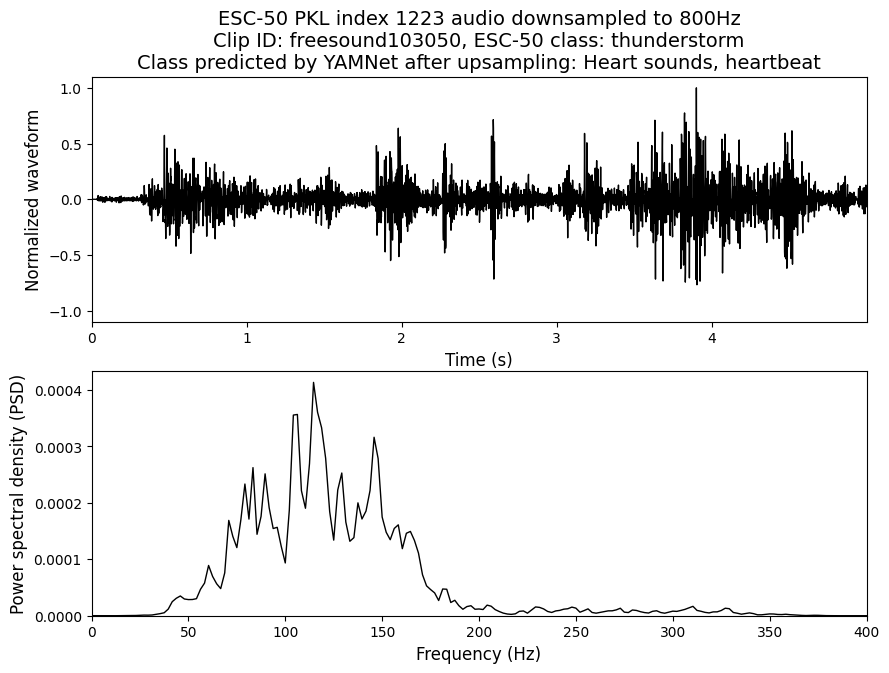

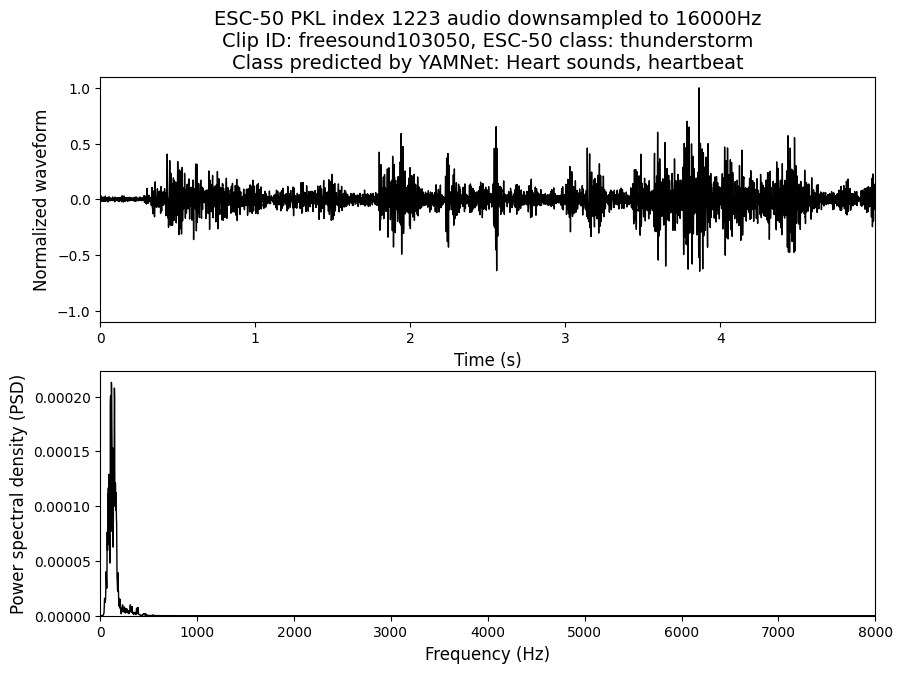

In [34]:
for ex_clip_df in [ex_clip_df_800, ex_clip_df_16k]:
    single_sample_example_plots(
        esc50_ds=ex_clip_df,
        ds_labels=ds_labels,
        sample_idx=ex_clip_df.index[0],
        plot_tfr=False)

If we want to generate the time frequency representations, we can call the same plotting function but with `plot_tfr=True`.

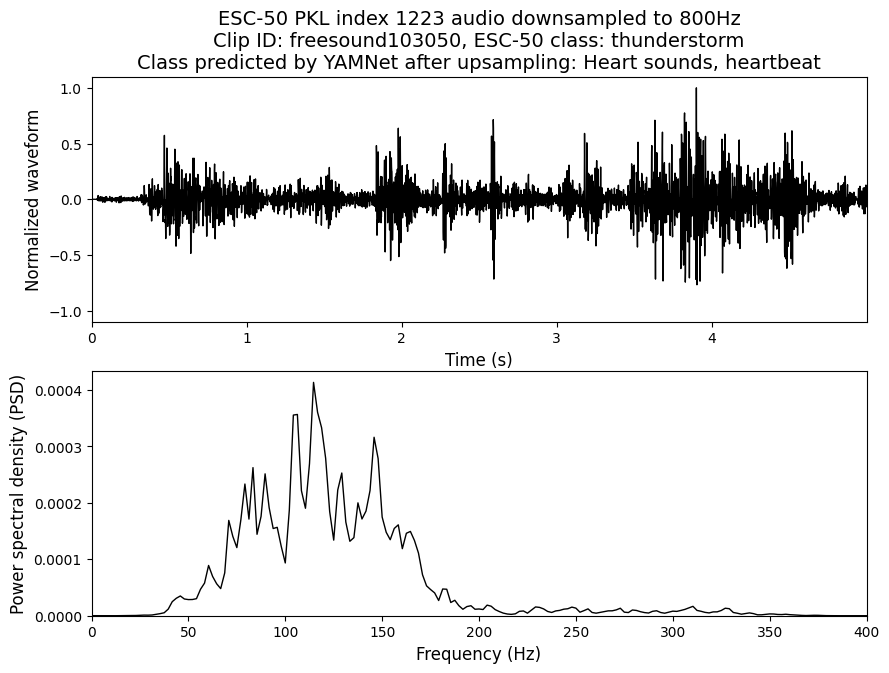

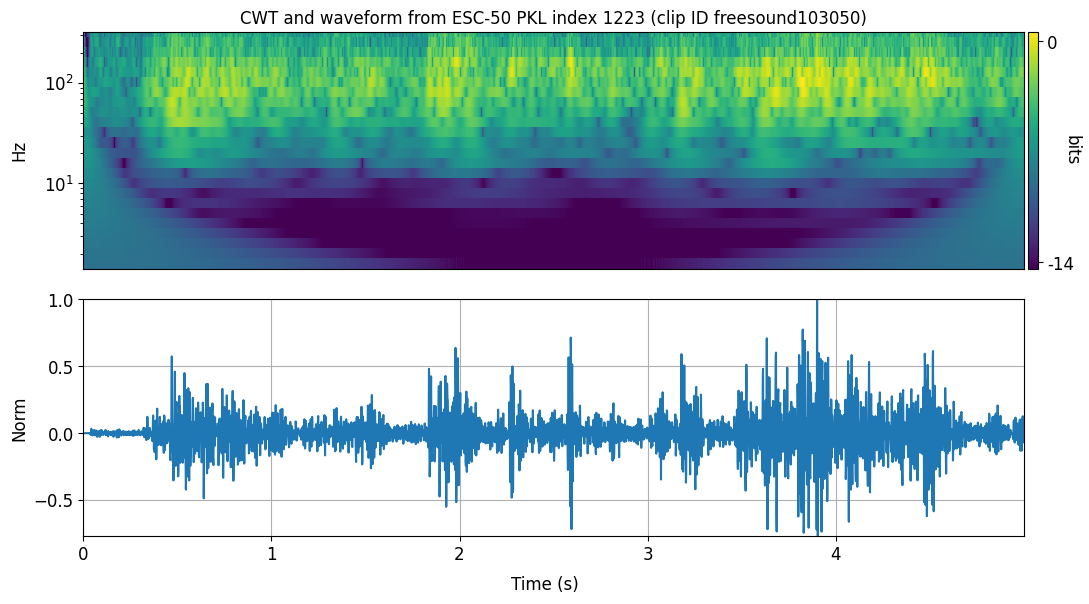

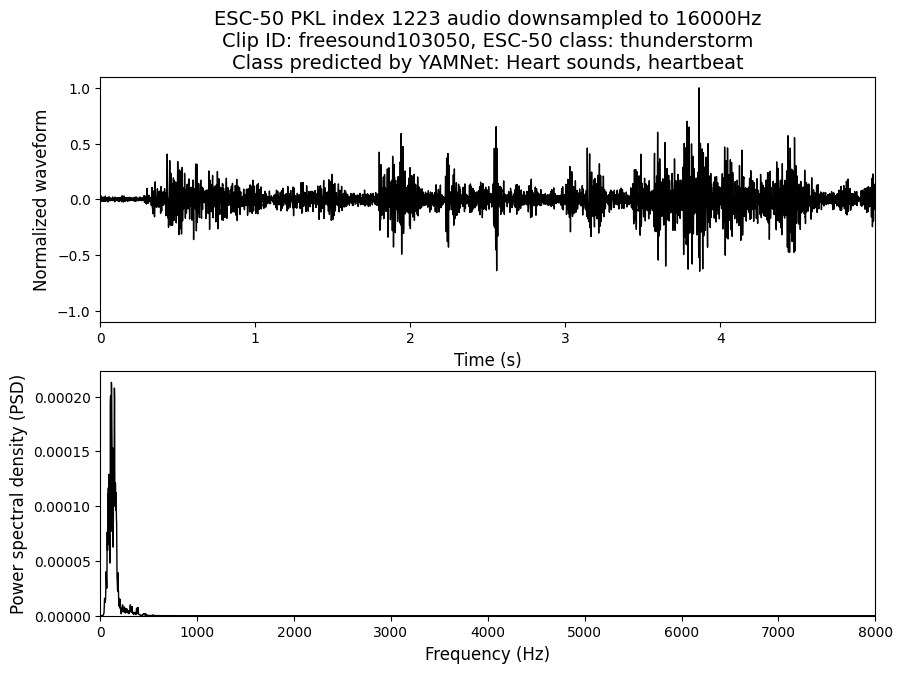

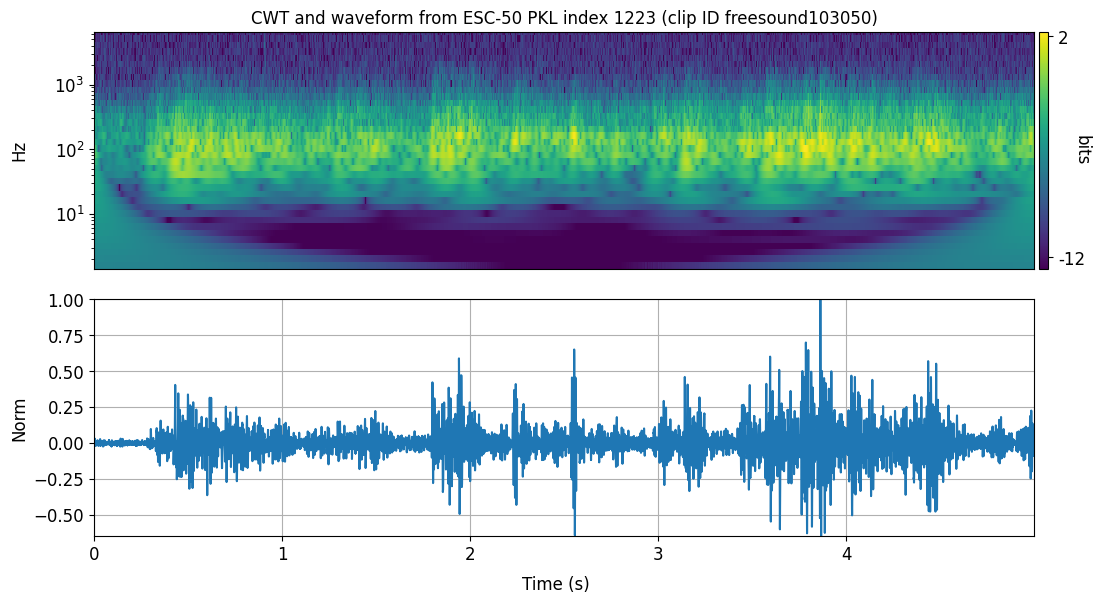

In [35]:
for ex_clip_df in [ex_clip_df_800, ex_clip_df_16k]:
    single_sample_example_plots(
        esc50_ds=ex_clip_df,
        ds_labels=ds_labels,
        sample_idx=ex_clip_df.index[0],
        plot_tfr=True)

If we're using PKL files with multiple samples, we can loop through and generate plots for each sample easily, but the cell will take a while to run (3-5s for each sample), so we'll limit it to the first 20 samples in the files.

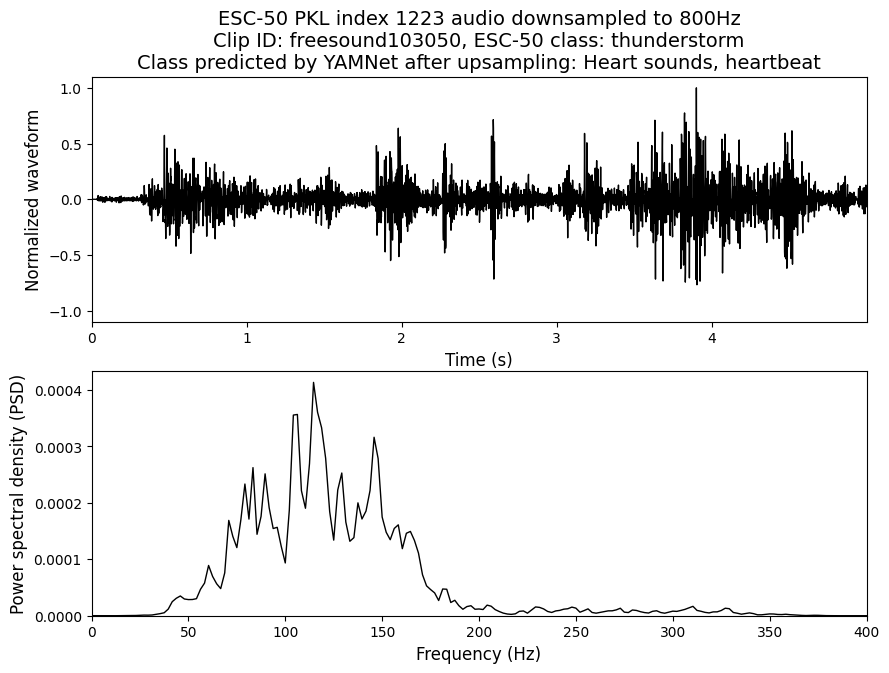

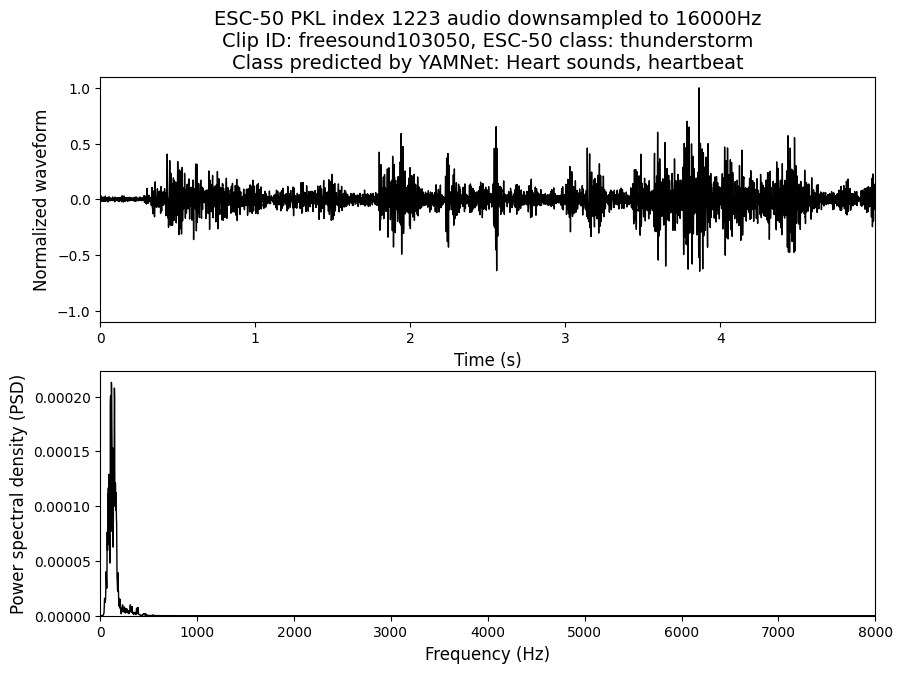

In [36]:
for idx in esc50_ds_800.index[:20]:
    for esc50_ds in [esc50_ds_800, esc50_ds_16k]:
        single_sample_example_plots(
            esc50_ds=esc50_ds,
            ds_labels=ds_labels,
            sample_idx=idx,
            plot_tfr=False)
    plt.show()

## Section 4: Saving ESC-50 Data

We can also save a subset of the data to a new pickle (.pkl) file. This can be useful in some cases as the full dataset is quite large and may not be needed for all applications.

We can save any subset (samples labeled 'dog', samples classified by YAMNet as 'clapping', etc.), but we'll stick with our example subset of data from a single Freesound clip. For this example, we'll save PKL files of our example thunderstorm clip, but this can be modified by simply changing the value of `clip_id_to_save`.

In [37]:
clip_id_to_save = "freesound103050"
for esc50_ds in [esc50_ds_800, esc50_ds_16k]:
    # Check if the clip id is in the dataset
    if clip_id_to_save in np.unique(esc50_ds[ds_labels.clip_id]):
        subset_to_save = esc50_ds[esc50_ds[ds_labels.clip_id] == clip_id_to_save]
        # Print some details about the subset
        n_samples = len(subset_to_save)
        classes, class_counts = np.unique(subset_to_save[ds_labels.esc50_true_class], return_counts=True)
        print_string = f"Selected clip: {clip_id_to_save}, ESC-50 classes:"
        for class_name, class_count in zip(classes, class_counts):
            print_string += f" {class_name} ({class_count} sample(s)),"
        print(print_string[:-1])
        
        # Save the subset DataFrame to a new pickle file
        if esc50_ds[ds_labels.audio_fs][esc50_ds.index[0]] == 800:
            output_filename = f"esc50_{clip_id_to_save}_800Hz.pkl"
        else:
            output_filename = f"esc50_{clip_id_to_save}_16kHz.pkl"
        output_path = os.path.join(CURRENT_DIRECTORY, output_filename)
        print(f"Saving ESC-50 data from clip {clip_id_to_save} to: {output_path}")
        subset_to_save.to_pickle(output_path)
    else:
        print("Requested data not found. No file saved.")

Selected clip: freesound103050, ESC-50 classes: thunderstorm (1 sample(s))
Saving ESC-50 data from clip freesound103050 to: /Users/spopen/vscode_repos/UH_Soundscapes/sandbox/sarah/esc50_freesound103050_800Hz.pkl
Selected clip: freesound103050, ESC-50 classes: thunderstorm (1 sample(s))
Saving ESC-50 data from clip freesound103050 to: /Users/spopen/vscode_repos/UH_Soundscapes/sandbox/sarah/esc50_freesound103050_16kHz.pkl


This concludes the tutorial. For more details on ESC-50, see the references listed at the beginning of the tutorial.